In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [5]:
# @title Helper functions

def get_eigval_specified_matrix(target_eig):
  """Generates matrix with specified eigvals

    Args:
      target_eig (list): list of target eigenvalues, can be real or complex,
              should be length 2 unless you desire repeated eigenvalues
              with the same eigenvector, in which case length 1

    Returns:
      ndarray: 2 x 2 matrix with target eigvals

  """

  # Set up two eigenvectors
  V = np.array([[1, 1], [-1, 1]]).astype('float')
  for i in range(2):
    V[:, i] = V[:, i]/np.linalg.norm(V[:, i])

  # Get matrix with target eigenvalues
  if type(target_eig[0]) == int or type(target_eig[0]) == float:

    if len(target_eig) == 2: # distinct eigvecs (not necessarily distinct eigvals)

        D = np.diag(target_eig)
        A = V @ D @ np.linalg.inv(V)

    else: # repeated with same vec
      summed = 2*target_eig[0]

      a = summed - 3
      d = 3
      bc = target_eig[0]**2 - a*d
      factors = [n for n in range(1, bc+ 1) if bc % n == 0]
      b = factors[int(np.floor(len(factors)/2))]
      c = bc/-b

      A = np.array([[a, b], [c, d]])

  elif type(target_eig[0]) == complex:

      C = [np.real(V[:,0]), np.real(V[:,1])]
      B = np.array([[np.real(target_eig[0]), np.imag(target_eig[0])],
                    [-np.imag(target_eig[0]), np.real(target_eig[0])]]).squeeze()
      A = C @ B @ np.linalg.inv(C)

  return A

In [6]:
# @title Plotting functions

def plot_circuit_responses(u, W, eigenstuff = False,
                           xlim='default',
                           ylim='default'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Set up axis limits
    if xlim == 'default':
      extreme = np.maximum(np.abs(np.min(u)), np.max(u))
      xlim = [- extreme, extreme]
    if ylim == 'default':
      extreme = np.maximum(np.abs(np.min(u)), np.max(u))
      ylim = [- extreme, extreme]

    # Set up look
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    cs = plt.rcParams['axes.prop_cycle'].by_key()['color']*10
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set up tracking textz
    tracker_text = ax.text(.5, .9, "", color='w',
                           fontsize=20,
                           verticalalignment='top',
                           horizontalalignment='left',
                           transform=ax.transAxes)

    # Plot eigenvectors
    if eigenstuff:
      eigvals, eigvecs = np.linalg.eig(W)

      if np.abs(eigvals[0]) < np.abs(eigvals[1]):
        lc1 = 'c'
        lc2 = 'g'
      else:
        lc1 = 'g'
        lc2 = 'c'

      ax.plot(np.arange(-10000, 10000)*eigvecs[0, 0],
              np.arange(-10000, 10000)*eigvecs[1, 0],
              lc1, alpha=.5, label = r'$\mathbf{v}_1$')
      ax.plot(np.arange(-10000, 10000)*eigvecs[0, 1],
              np.arange(-10000, 10000)*eigvecs[1, 1],
              lc2, alpha=.5, label = r'$\mathbf{v}_2$')
      ax.legend()

    # Set up scatter
    cmap = plt.cm.coolwarm
    norm = plt.Normalize(vmin=0, vmax=u.shape[1])
    ax.plot(u[0,:], u[1, :], alpha=.4, zorder = 0)
    scatter = ax.scatter(u[0, :], u[1, :], alpha=1,
                         c=cmap(norm(np.arange(u.shape[1]))),
                         zorder=1)


    ax.set(xlabel='Neuron 1 Firing Rate ($a_1$)',
           ylabel='Neuron 2 Firing Rate ($a_2$)',
           title='Neural firing over time')

    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=ax, label='Time step')

# Implementing a neural circuit model
basically we make the time as discrete and model for n neurons, where the neurons are modelled to have connections with another neuron
and itself, which is not real in biology, but that's just an abstraction
\begin{aligned} a_{1, t} &= w_{1, 1}a_{1, t-1} + w_{2, 1}a_{2, t-1}\ a_{2, t} &= w_{1, 2}a_{1, t-1} + w_{2, 2}a_{2, t-1} \end{aligned}



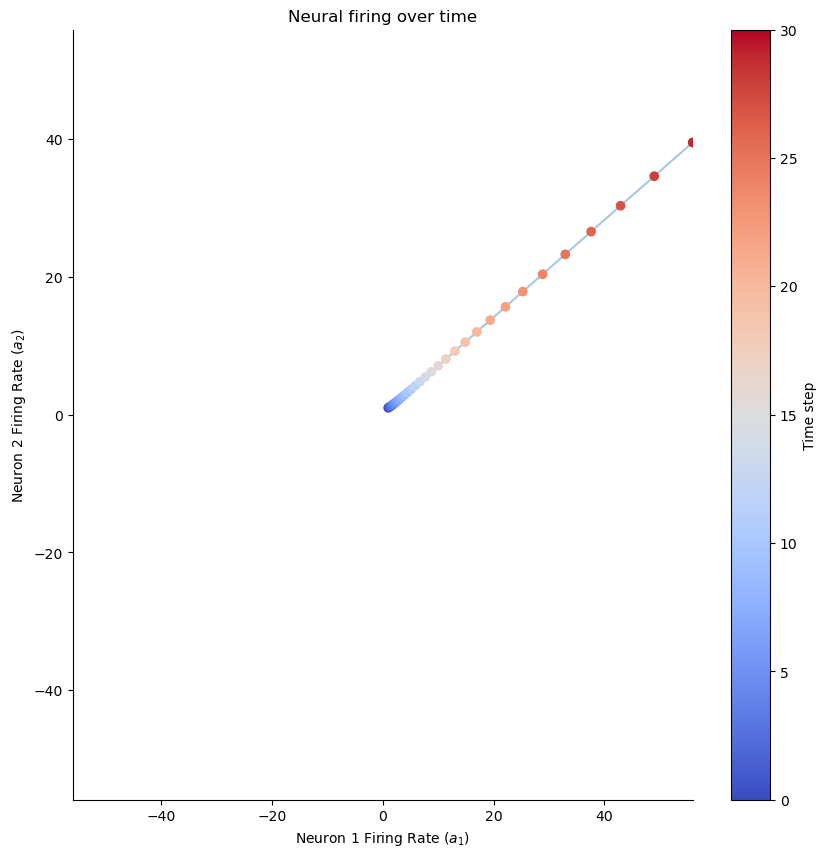

In [7]:
def circuit_implementation(W, a0, T):
  """ Simulate the responses of N neurons over time given their connections

  Args:
    W (ndarray): weight matrix of synaptic connections, should be N x N
    a0 (ndarray): initial condition or input vector, should be N,
    T (scalar): number of time steps to run simulation for

  Returns:
    a (ndarray): the neural responses over time, should be N x T

  """

  # Compute the number of neurons
  N = W.shape[0]

  # Initialize empty response array and initial condition
  a = np.zeros((N, T))
  a[:, 0]  = a0

  #################################################
  ## TODO for students ##
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: Complete circuit_implementation")
  #################################################

  # Loop over time steps and compute u(t+1)
  for i_t in range(1, T):
      a[:, i_t] = W @ a[:, i_t - 1]

  return a


# Define W, u0, T
W = np.array([[1, .2], [.1, 1]])
a0 = np.array([1, 1])
T = 30

# Get neural activities
a = circuit_implementation(W, a0, T)

# Visualize neural activities
plot_circuit_responses(a, W)

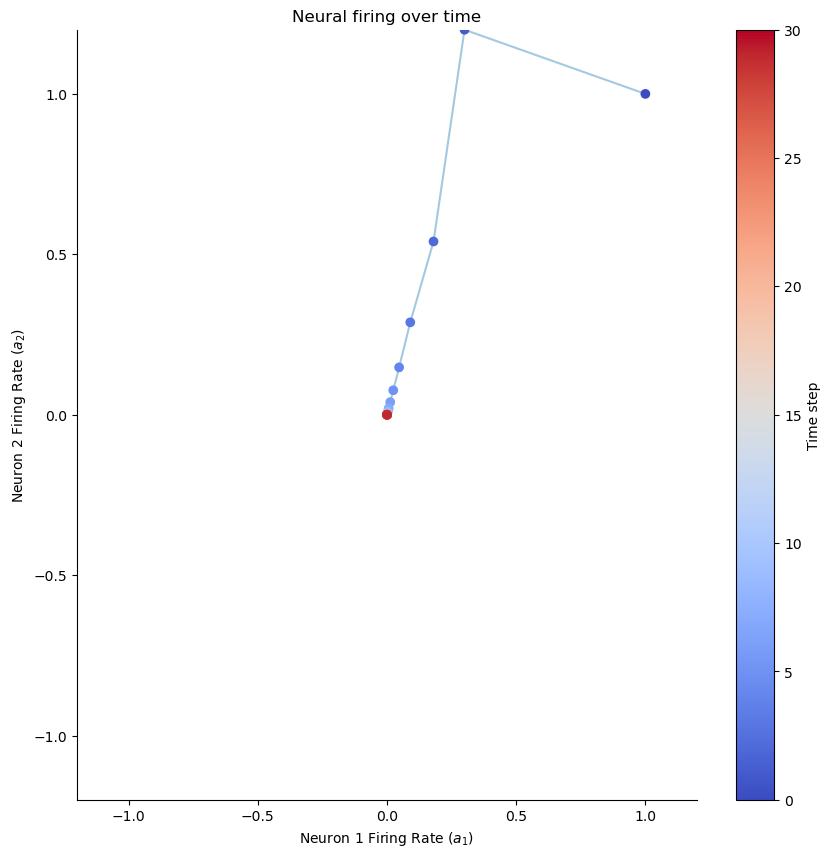

In [8]:
# Define W, a0, T
W = np.array([[.2, .1], [1, .2]])
a0 = np.array([1, 1])
T = 30

# Get neural activities
a = circuit_implementation(W, a0, T)

# Visualize neural activities
plot_circuit_responses(a, W)

In [9]:
from ipywidgets import widgets


# @markdown Execute this cell to enable the widget. Please be patient for a few seconds after you change the slider

@widgets.interact(eigenvalue = widgets.FloatSlider(value=0.5, min=-2, max=2, step=0.2))
def plot_system(eigenvalue):

  # Get weight matrix with specified eigenvalues
  W = get_eigval_specified_matrix([eigenvalue, eigenvalue])

  # Get initial condition
  u0 = np.array([1, 1])

  # Get neural activities
  u = circuit_implementation(W, u0, 10)

  # Visualize neural activities
  plot_circuit_responses(u, W, eigenstuff = True, xlim = [-15, 15], ylim = [-15, 15])

interactive(children=(FloatSlider(value=0.5, description='eigenvalue', max=2.0, min=-2.0, step=0.2), Output())…


# understanding general dynamics using eigenstuff
\begin{aligned}
a_{i} &= c_{1} \cdot \lambda_{1}^2 \cdot v_{1} + c_{2} \cdot \lambda_{2}^2 \cdot v_{2}
\end{aligned}

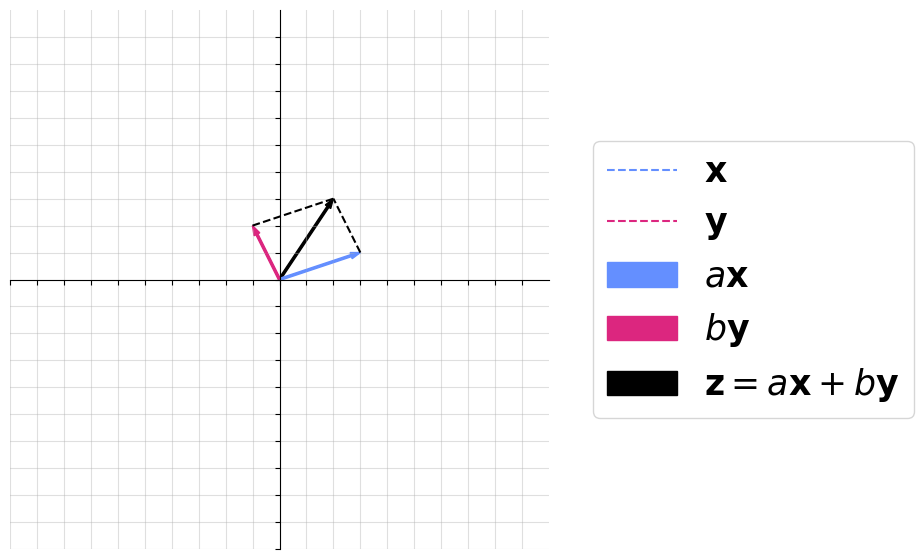

interactive(children=(FloatSlider(value=1.0, description='a', max=4.0, min=-4.0), FloatSlider(value=1.0, descr…

In [10]:
 #@markdown Make sure you execute this cell to enable the widget! Move the sliders for “a” and “b”. After releasing the slider, be patient for a couple of seconds to see the desired change.


def plot_arrows(x, y, a_times_x, b_times_y):
  fig, ax = plt.subplots(figsize=(10, 7))

  ax.spines['top'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')

  ax.set_aspect('equal', adjustable='box')
  ax.set(xlim = [-10, 10], ylim = [-10, 10], xticks = np.arange(-10, 10), yticks = np.arange(-10, 10), xticklabels = [], yticklabels = [])

  ax.grid(alpha=.4)

  z = a_times_x + b_times_y
  z_arr = ax.arrow(0, 0, z[0], z[1], width=.08, color='k', length_includes_head = True);

  x_orig, = ax.plot([0, x[0]], [0, x[1]], '--', color='#648FFF')
  y_orig, = ax.plot([0, y[0]], [0, y[1]], '--',  color='#DC267F')

  ax_arr = ax.arrow(0, 0, a_times_x[0], a_times_x[1], width=.08, color='#648FFF', length_includes_head = True);
  by_arr = ax.arrow(0, 0, b_times_y[0], b_times_y[1], width=.08, color='#DC267F', length_includes_head = True);

  ax.plot([a_times_x[0], z[0]], [a_times_x[1], z[1]], '--k')
  ax.plot([b_times_y[0], z[0]], [b_times_y[1], z[1]], '--k')


  leg = ax.legend([x_orig, y_orig, ax_arr, by_arr, z_arr], [r"$\mathbf{x}$", r"$\mathbf{y}$", r"$a\mathbf{x}$", r"$b\mathbf{y}$", r"$\mathbf{z} = a\mathbf{x} + b\mathbf{y}$"], handlelength = 2, fontsize = 25, loc = 'center left', bbox_to_anchor=(1.05, .5))
  for handle, label in zip(leg.legendHandles, leg.texts):
      try:
          label.set_color(handle.get_facecolor())
      except:
          label.set_color(handle.get_color())
      #handle.set_visible(False)

@widgets.interact(a = widgets.FloatSlider(value=1.0, min=-4, max=4, step=0.1), b = widgets.FloatSlider(value=1.0, min=-4, max=4, step=0.1))
def plot_linear_combination(a, b):
  x = np.array([3, 1])
  y = np.array([-1, 2])

  plot_arrows(x, y, a*x, b*y)

In [11]:
# @markdown Execute this cell to enable the widget (there is a small lag so be patient after changing sliders)
eigenvalue1 = widgets.FloatSlider(value=0.5, min=0.2, max=2, step=0.2)
eigenvalue2 = widgets.FloatSlider(value=0.2, min=0.2, max=0.5, step=0.2)
a0_1 = widgets.FloatSlider(value=1, min=-5, max=5, step=0.2)
a0_2 = widgets.FloatSlider(value=2, min=-5, max=5, step=0.2)

def update_range(*args):
    eigenvalue2.max = eigenvalue1.value - 0.2
eigenvalue1.observe(update_range, 'value')


def plot_system(eigenvalue1, eigenvalue2, a0_1, a0_2):

  # Get initial condition
  a0 = np.array([a0_1, a0_2])

  # Get weight matrix with specified eigenvalues
  W = get_eigval_specified_matrix([eigenvalue1, eigenvalue2])

  # Get neural activities
  u = circuit_implementation(W, a0, 10)

  # Visualize neural activities
  plot_circuit_responses(u, W, eigenstuff = True, xlim = [-15, 15], ylim = [-15, 15])

widgets.interact(plot_system, eigenvalue1 = eigenvalue1, eigenvalue2 = eigenvalue2, a0_1 = a0_1, a0_2 = a0_2)

interactive(children=(FloatSlider(value=0.5, description='eigenvalue1', max=2.0, min=0.2, step=0.2), FloatSlid…

<function __main__.plot_system(eigenvalue1, eigenvalue2, a0_1, a0_2)>